## Final Model for sby_need

Predict sby_need with predicted calls with RandomForest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pprint import pprint
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, QuantileRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV

In [2]:
import sys
print(sys.executable)

/Users/kata/opt/anaconda3/bin/python


In [3]:
# load data
# feature engineering
df = pd.read_csv('/Users/kata/Desktop/GitHub/standby_duty_forecasting/sickness_table.csv', index_col=0)
df['date'] = pd.to_datetime(df['date'])
df['year']= df['date'].dt.year
df['month']= df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['week'] = df['date'].dt.isocalendar().week
df['day_of_month'] = df['date'].dt.day
df['day_of_year'] = df['date'].dt.dayofyear
# change type to not get error
df['week'] = df['week'].astype(np.int64)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1152 entries, 0 to 1151
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1152 non-null   datetime64[ns]
 1   n_sick        1152 non-null   int64         
 2   calls         1152 non-null   float64       
 3   n_duty        1152 non-null   int64         
 4   n_sby         1152 non-null   int64         
 5   sby_need      1152 non-null   float64       
 6   dafted        1152 non-null   float64       
 7   year          1152 non-null   int64         
 8   month         1152 non-null   int64         
 9   day_of_week   1152 non-null   int64         
 10  week          1152 non-null   int64         
 11  day_of_month  1152 non-null   int64         
 12  day_of_year   1152 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(9)
memory usage: 126.0 KB


In [4]:
# predict calls with RF
# define X and y data
X = df[['year', 'month', 'day_of_week',
       'week', 'day_of_month', 'day_of_year']]
y = df.calls

In [5]:
# train test split
def train_test_split(data, n_test):
	return data[:n_test], data[n_test:]


x_train, x_test = train_test_split(X, 922)
y_train, y_test = train_test_split(y, 922)

In [6]:
# train first model
# no tuned parameters
model = RandomForestRegressor(n_estimators=1000, random_state=6)
model.fit(x_train, y_train)
pred = model.predict(x_test)

In [7]:
# calculte RMSE and MSE
print('RMSE:', np.sqrt(mean_squared_error(y_test, pred)))
print('MSE:', mean_squared_error(y_test, pred))

RMSE: 1236.0084043773995
MSE: 1527716.7756915651


Leave sby_need out:

#### Prepare for visualization

In [10]:
# visualization
# Dates of the actual training values
months = X['month']
days = X['day_of_month']
years = X['year']

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]


# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': y})

In [11]:
# Dates of the predictions
months = x_test['month']
days = x_test['day_of_month']
years = x_test['year']

# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]
# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': pred})

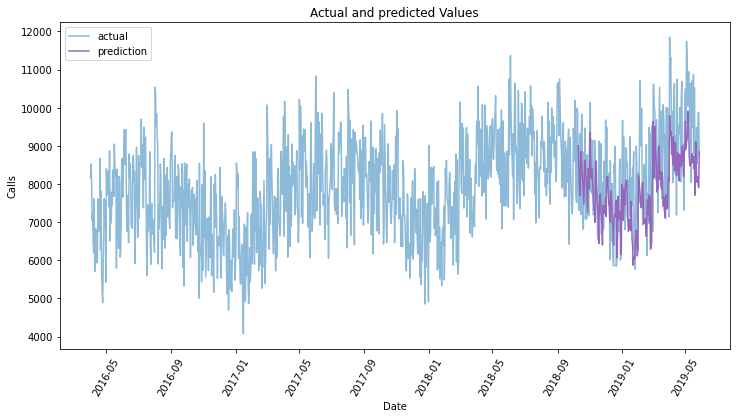

In [12]:
# plot prediction and actual values
plt.figure(figsize=(12,6))
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual', alpha=0.5, color='tab:blue')
# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], label = 'prediction', color='tab:purple')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('Calls'); plt.title('Actual and predicted Values');

### Hyperparameter Tuning

In [13]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(model.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 6,
 'verbose': 0,
 'warm_start': False}


In [ ]:
# grid search
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [ ]:
# Create the random grid
#random_grid = {'n_estimators': n_estimators,
#               'max_features': max_features,
#               'max_depth': max_depth,
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf,
#               'bootstrap': bootstrap}

In [ ]:
# pprint(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# model = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
# model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
#model_random.fit(x_train, y_train)

In [ ]:
# view best parameters
#model_random.best_params_

Best parameters:
{'n_estimators': 2000,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [14]:
# Evaluate Random Search
# To determine if random search yielded a better model, we compare the base model with the best random search model.
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    mse = mean_squared_error(test_labels, predictions)
    rmse = np.sqrt(mse)
    print('Model Performance')
    print('Mean Squared Error: {:0.2f}'.format(mse))
    print('Root Mean Squared Error: {:0.2f}'.format(rmse))
    
    return rmse, mse


In [15]:
base_model = RandomForestRegressor(n_estimators = 1000, random_state = 6)
base_model.fit(x_train, y_train)
evaluate(base_model, x_test, y_test)

Model Performance
Mean Squared Error: 1527716.78
Root Mean Squared Error: 1236.01


(1236.0084043773995, 1527716.7756915651)

In [ ]:
#best_random = model_random.best_estimator_
#evaluate(best_random, x_test, y_test)

Performance got better with the new parameters, now we get even more specific with grid search

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [0, 10, 20],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [3, 5, 7],
    'n_estimators': [1800, 2000, 2200]
}

# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
#grid_search.fit(x_train, y_train)

In [ ]:
#grid_search.best_params_

best params:
<br>
{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 1800}

In [ ]:
best_grid = grid_search.best_estimator_
evaluate(best_grid, x_test, y_test)

--> slightly better

### Make final prediction with new parameters

In [16]:
rf = RandomForestRegressor(bootstrap=True, max_depth=10, max_features='sqrt', 
min_samples_leaf=1, min_samples_split=7, n_estimators=1800, random_state=6)
rf.fit(x_train, y_train)
pred = rf.predict(x_test)
evaluate(rf, x_test, y_test)


Model Performance
Mean Squared Error: 1475635.44
Root Mean Squared Error: 1214.76


(1214.757358200772, 1475635.4393029185)

In [17]:
# prepare for visualization
# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': pred})

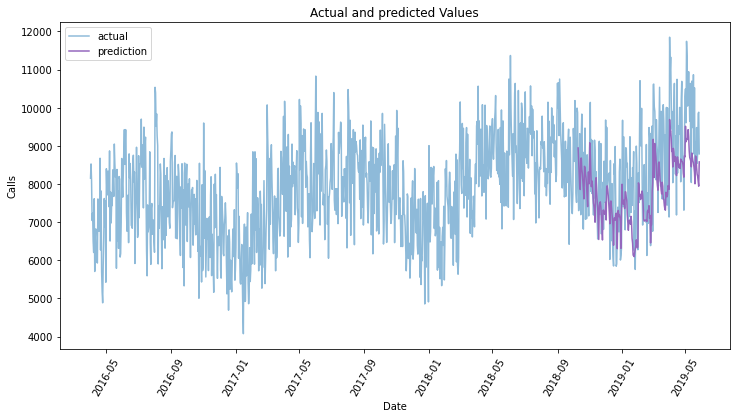

In [18]:
# plot new predictions
# plot prediction and actual values
plt.figure(figsize=(12,6))
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual', alpha=0.5, color='tab:blue')
# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], label = 'prediction', color='tab:purple')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('Calls'); plt.title('Actual and predicted Values');

## Predict sby_need with predicted calls

In [19]:
# create new df with predicted calls
calls_new = pd.concat([df['calls'].iloc[:922], predictions_data['prediction']], axis=0).reset_index(drop=True)
intermediate_df = df.copy()
intermediate_df['calls_new'] = calls_new

In [20]:
# define new X and y
X = intermediate_df[['year', 'month', 'day_of_week', 
       'week', 'n_duty', 'day_of_month', 'day_of_year', 'calls_new']]
y = intermediate_df['sby_need']

In [21]:
# train test split
x_train, x_test = train_test_split(X, 922)
y_train, y_test = train_test_split(y, 922)


In [22]:
# train basic RF for feature importance
forest = RandomForestRegressor(n_estimators=1000, random_state=6)
forest.fit(x_train, y_train)
pred = forest.predict(x_test)

In [23]:
## get feature importance before final model!!!
feature_list = list(X.columns)
pprint(feature_list)

['year',
 'month',
 'day_of_week',
 'week',
 'n_duty',
 'day_of_month',
 'day_of_year',
 'calls_new']


In [24]:
# Get numerical feature importances
importances = list(forest.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: calls_new            Importance: 0.88
Variable: year                 Importance: 0.06
Variable: n_duty               Importance: 0.05
Variable: month                Importance: 0.0
Variable: day_of_week          Importance: 0.0
Variable: week                 Importance: 0.0
Variable: day_of_month         Importance: 0.0
Variable: day_of_year          Importance: 0.0


In [25]:
# we decide to one hot encode the year for prediction

In [26]:
# one hot encode day of year
one_hot_year = pd.get_dummies(intermediate_df['year'], prefix='year')
intermediate_df = intermediate_df.join(one_hot_year)



In [204]:
# new Y and y with only one hot encoded year
X = intermediate_df[['n_duty', 'calls_new',
       'year_2016', 'year_2017', 'year_2018', 'year_2019']]
y = intermediate_df['sby_need']


In [205]:
# train test split
x_train, x_test = train_test_split(X, 922)
y_train, y_test = train_test_split(y, 922)

In [206]:
# predict sby_need with QuantileRegressor
quantile_model = QuantileRegressor(quantile=0.95, alpha=0.25)
quantile_model.fit(x_train, y_train)
pred = quantile_model.predict(x_test)
pred = pd.Series(pred)

In [207]:
# eliminate values <0, round to nearest integer
pred = pred.apply(lambda x: 0 if x < 0 else x)
pred = np.round(pred)

In [208]:
# prepare for visualization
# Dataframe with predictions and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': y})
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': pred})

In [209]:
# evaluate
evaluate(quantile_model, x_test, y_test)

Model Performance
Mean Squared Error: 12976.28
Root Mean Squared Error: 113.91


(113.91346331599654, 12976.27712464489)

In [210]:

quantile_model.coef_

array([-1.49095477e-01,  5.77889447e-02,  2.26094209e-12,  8.26327849e-12,
       -9.77624701e-12,  0.00000000e+00])

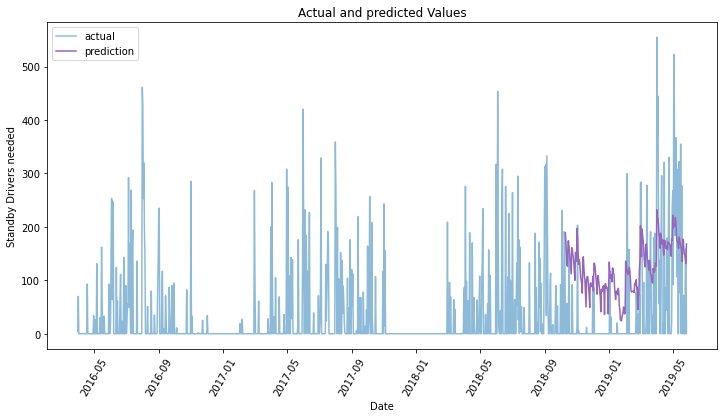

In [211]:
# plot new predictions
# plot prediction and actual values
plt.figure(figsize=(12,6))
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual', alpha=0.5, color='tab:blue')
# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], label = 'prediction', color='tab:purple')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('Standby Drivers needed'); plt.title('Actual and predicted Values');

In [212]:
# create new df with predictions
df_final = intermediate_df.copy()
sby_need_predicted = pd.concat([intermediate_df['sby_need'].iloc[:922], pred], axis=0).reset_index(drop=True)
df_final['sby_need_predicted'] = sby_need_predicted
# create new df for testing timeframe
df_final_eval = df_final[922:]
df_final_eval = df_final_eval.reset_index(drop=True)
df_final_eval.shape

(230, 19)

In [213]:
# check how many times we are understaffed - predicted vs actual
df_final_eval['understaffed'] = np.where(df_final_eval['sby_need_predicted'] < df_final_eval['sby_need'], 1, 0)
df_final_eval['overstaffed'] = np.where(df_final_eval['sby_need_predicted'] > df_final_eval['sby_need'], 1, 0)
df_final_eval['exact_match'] = np.where(df_final_eval['sby_need_predicted'] == df_final_eval['sby_need'], 1, 0)
understaffed = df_final_eval['understaffed'].sum()
overstaffed = df_final_eval['overstaffed'].sum()
df_final_eval['percentage'] = df_final_eval['sby_need_predicted']/df_final_eval['sby_need']
df_final_eval.percentage = df_final_eval.percentage.replace([np.inf, -np.inf], 0.0)
#df_final_eval.percentage = df_final_eval.percentage.apply(lambda x: df_final_eval.sby_need_predicted if x == np.nan else x)
percentage = df_final_eval['percentage'].mean()
print('Understaffed: {} days,'.format(understaffed), 'Percent: {}%'.format(understaffed/len(df_final_eval)*100))
print('Overstaffed: {} days,'.format(overstaffed), 'Percent: {}%'.format(overstaffed/len(df_final_eval)*100))
print('Percentage activated: {}%'.format(percentage*100))

Understaffed: 36 days, Percent: 15.65217391304348%
Overstaffed: 194 days, Percent: 84.34782608695653%
Percentage activated: 83.8239830200177%
